<a href="https://colab.research.google.com/github/flavio-mota/fundamentos-pln/blob/master/An%C3%A1lise_de_Sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:#336699">Análise de Sentimentos em Português: MLP vs BERTimbau</span>
<hr style="border:2px solid #0077b9;">

<br/>

<div style="text-align: center;font-size: 90%;">
    Autores: <br/>
    Flávio Belizário da Silva Mota <br/>
    Isabela Neves Drummond
    <br/>
</div>

<br/>
<br/>

# Introdução

A análise de sentimentos é uma tarefa clássica do Processamento de Linguagem Natural (PLN) que busca identificar a polaridade de opiniões expressas em textos. Com aplicações que vão desde a análise de comentários de usuários em plataformas de e-commerce até a monitoria de redes sociais, a tarefa pode ser resolvida por diferentes abordagens.

Neste notebook, exploraremos duas formas distintas de realizar essa tarefa em textos escritos em português:
1. Uma abordagem baseada em um classificador tradicional: MLP (Perceptron Multicamadas) usando vetores TF-IDF como representação dos textos.
2. Uma abordagem baseada em modelos de linguagem pré-treinados, especificamente o BERTimbau, uma versão do modelo BERT treinada para a língua portuguesa.

Com isso, queremos evidenciar as vantagens e limitações de cada abordagem ao aplicar a análise de sentimentos em avaliações reais de usuários sobre aplicativos.

Vamos carregar um arquivo que contem avaliações de diversos aplicativos de delivery:

In [ ]:
import pandas as pd

# Baixar e extrair o dataset do OpenReviews (subset em PT-BR)
url = "https://raw.githubusercontent.com/flavio-mota/fundamentos-pln/refs/heads/master/reviews.csv"
df = pd.read_csv(url)
df = df[['content', 'sentiment']].rename(columns={'content': 'texto', 'sentiment': 'sentimento'})
df['sentimento'] = df['sentimento'].astype(int)

df

Existe uma coluna chamada "sentimento" que determina qual o sentimento associado ao comentário. O valor 0 indica comentários com sentimento negativo, o valor 1 indica comentários com sentimento positivo e o valor 2 indica comentários com sentimentos positivos. Vamos visualizar a distribuição das classes:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentimento')
plt.title("Distribuição dos Sentimentos")
plt.xlabel("Classe (0 = Negativo, 1 = Neutro, 2 = Positivo)")
plt.ylabel("Quantidade")
plt.show()

# Pré-processamento e vetorização

Vamos dividir o conjunto em treinamento e teste e extrair as características usando o TF-IDF:

In [ ]:
from sklearn.model_selection import train_test_split

X = df['texto']
y = df['sentimento']

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Treinando com MLP

A MLP (Multilayer Perceptron) é uma rede neural artificial composta por múltiplas camadas de neurônios: uma camada de entrada, uma ou mais camadas ocultas e uma camada de saída. Cada neurônio em uma camada está totalmente conectado aos neurônios da próxima camada.

image4_74e3e8d76f.avif

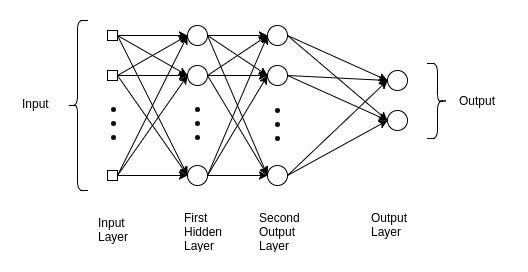

Nesta implementação utilizamos:
- `hidden_layer_sizes=(10,10)`: define duas camadas ocultas com 10 neurônios em cada.
- `activation='tanh'`: função de ativação a ser usada (tangente hiperbólica).
- `max_iter=300`: número máximo de iterações durante o treinamento. Um valor moderado para garantir que o modelo tenha tempo suficiente para convergir.
- `random_state=42`: fixa a semente de aleatoriedade, garantindo reprodutibilidade dos resultados.

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(10,10,), activation='tanh', max_iter=300, random_state=42)

In [ ]:
%time clf.fit(X_train_tfidf, y_train)

Analisando o desempenho da rede:

In [ ]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test_tfidf)
print("\nRelatório de Classificação - MLP")
print(classification_report(y_test, y_pred, digits=3))

Claramente a rede não obteve um bom desempenho. Nós teriamos que testar algumas configurações de rede que permitissem melhorar o desempenho do modelo.

# Classificando com modelos pré-treinados: BERTimbau

BERTimbau é um modelo baseado na arquitetura BERT, treinado especificamente com textos em português. Ele permite capturar de forma mais eficaz o contexto e o significado das palavras no idioma, sendo altamente eficaz em tarefas como análise de sentimentos.

Usaremos um modelo baseado no BERTimbau que foi ajustado (fine-tuned) para análise de sentimentos: o `stevillis/bertimbau-finetuned-glassdoor-reviews`.

Esse modelo retorna rótulos como `positive`, `neutral` ou `negative` e é uma excelente opção para lidar com textos em português em tarefas de classificação de sentimentos.

A Hugging Face é uma plataforma que centraliza uma série de modelos de PLN, oferecendo ferramentas prontas para uso, como o `pipeline` para análise de sentimentos. Esse pipeline encapsula o tokenizador e o modelo, permitindo realizar predições de forma simples.

In [ ]:
from transformers import pipeline

# Carregar o pipeline de análise de sentimentos com o modelo fine-tunado
sent_pipeline = pipeline("text-classification", model="stevillis/bertimbau-finetuned-glassdoor-reviews")

In [ ]:
# Comparar com os dados rotulados
amostras_com_rotulo = df.sample(5, random_state=72)[['texto', 'sentimento']]

print("\nComparação entre rótulo original e modelo BERTimbau fine-tuned:")
for _, linha in amostras_com_rotulo.iterrows():
    texto = linha['texto']
    rotulo_original = linha['sentimento']
    pred = sent_pipeline(texto)[0]
    print("Texto:", texto)
    print("Rótulo original:", rotulo_original)
    print("Predição do modelo:", pred['label'], "- Confiança:", round(pred['score'], 2))
    print("---")